In [2]:
import pennylane as qml
from pennylane import numpy as np

[0.00000000e+00 0.00000000e+00 5.20657517e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.32840070e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.27620372e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.49232706e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.78017023e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.89026811e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.36753667e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.21227225e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.51252435e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.342414

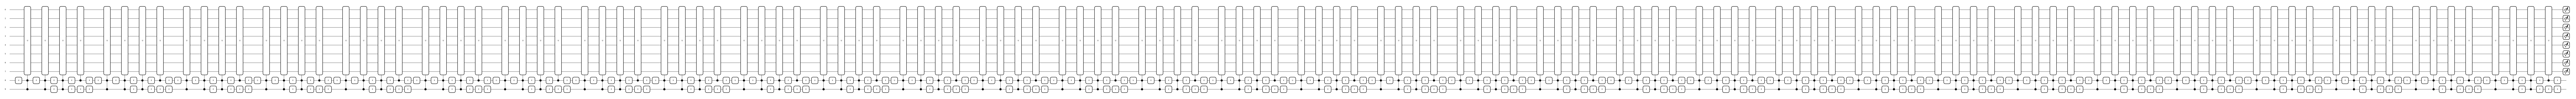

In [ ]:
position_n = 8
dev = qml.device("default.qubit", wires=position_n+2)
allThetas = []

def coin(m):
    theta = (((m + 37) % 256) / 255) * 2 * np.pi
    allThetas.append(theta)
    U = np.array([
        [np.cos(theta), np.sin(theta)],
        [np.sin(theta), -np.cos(theta)]
    ])  # This is Pauli-X for example

    qml.QubitUnitary(U, wires=position_n)

def c_increment_gate():
    dim = 2 ** position_n
    mat = np.zeros((dim,dim))
    for i in range(dim):
        mat[(i + 1) % dim, i] = 1
    qml.ControlledQubitUnitary(
        mat,
        control_wires=[position_n,position_n+1],
        wires=[i for i in range(position_n)]
    )

def c_decrement_gate():
    dim = 2 ** position_n
    mat = np.zeros((dim,dim))
    for i in range(dim):
        mat[(i - 1) % dim, i] = 1
    qml.PauliX(wires=position_n)
    qml.ControlledQubitUnitary(
        mat,
        control_wires=[position_n,position_n+1],
        wires=[i for i in range(position_n)]
    )
    qml.PauliX(wires=position_n)

def c_increment_gate_lively(beta):
    dim = 2 ** position_n
    mat = np.zeros((dim,dim))
    for i in range(dim):
        mat[(i + beta) % dim, i] = 1
    qml.PauliX(wires=position_n+1)

    qml.ControlledQubitUnitary(
        mat,
        control_wires=[position_n,position_n+1],
        wires=[i for i in range(position_n)]
    )
    qml.PauliX(wires=position_n+1)


def c_decrement_gate_lively(beta):
    dim = 2 ** position_n
    mat = np.zeros((dim,dim))
    for i in range(dim):
        mat[(i - beta) % dim, i] = 1
    qml.PauliX(wires=position_n)
    qml.PauliX(wires=position_n+1)
    qml.ControlledQubitUnitary(
        mat,
        control_wires=[position_n],
        wires=[i for i in range(position_n)]
    )
    qml.PauliX(wires=position_n)
    qml.PauliX(wires=position_n+1)

bitlist = np.random.randint(0,2,256)

def bits_to_bytes(bits):
    bit_groups = bitlist.reshape(-1, 8)
    bytes_array = np.packbits(bit_groups, axis=1)
    return bytes_array.flatten()

# Write a function that CNOTS between randomly sampled pairs of gates based on some seed
def cnots():
    


@qml.qnode(dev)
def circuit(bitlist):
    bytelist = bits_to_bytes(bitlist)
    i = 0
    for b in bytelist:
        coin(b)
        c_increment_gate()
        c_decrement_gate()

        c_increment_gate_lively(4)
        c_decrement_gate_lively(3)
        #cnot_pairs(i)
        i += 1

    return qml.probs(wires=[i for i in range(position_n)])

#Draw Circuit Matplotlib
def draw_circuit(x):
    qml.draw_mpl(circuit)(x)
    return None

probs = circuit(bitlist)
draw_circuit(bitlist)
print(probs)

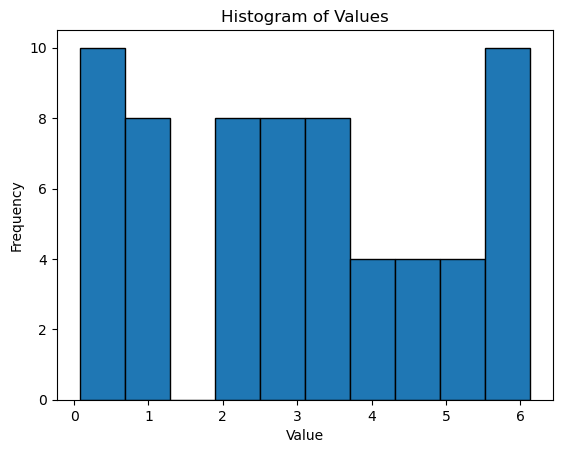

In [133]:
import matplotlib.pyplot as plt

# Sample data

# Create histogram
plt.hist(allThetas, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Show plot
plt.show()

In [120]:
# Checking if incr/decr function works

@qml.qnode(dev)
def circuit():
    dim = 2 ** position_n
    mat = np.zeros((dim,dim))
    for i in range(dim):
        mat[(i + 1) % dim, i] = 1
    qml.QubitUnitary(
        mat,
        wires=[i for i in range(position_n)]
    )
    return qml.probs(wires=[i for i in range(position_n)])

probs = circuit()
print(probs)

[0. 1. 0. 0.]


In [124]:
bytenums = (np.argsort(probs) % 256)

def to_bits(bytenums,maxlen=32):
    bitarr = []
    for b in bytenums[:maxlen]:
        for i in range(8):
            mask = 1 << i
            if (mask & b) > 0: bitarr.append(1)
            else: bitarr.append(0) 
    return bitarr

def to_bitstring(bytenums,maxlen=32):
    res = ""
    for b in (to_bits(bytenums,maxlen=maxlen)):
        res += str(b)
    return res

hashed_bitstring = (to_bitstring(bytenums))
print(len(hashed_bitstring))

256


In [125]:
def compute_hash(n):
    print(n)
    n = int(n)
    n_bits = 256
    bitlist = [int(b) for b in format(n, f"0{n_bits}b")]

    probs = circuit(bitlist)
    bytenums = (np.argsort(probs) % 256)
    hashed_bitstring = (to_bitstring(bytenums))
    return hashed_bitstring

def hash_collisions():
    prev = []
    for i in range(0,int(1e6)):
        hash = compute_hash(i)
        prev.append(hash)
        if hash in prev:
            print(f"Collision found: {hash} for {i}")
            return hash

hash_collisions()

0
Collision found: 1111111000100101101001010110010111100101000101011001010101010101110101010011010110110101110001010111010100001101100011010100110111001101001011011010110101101101111011010001110110011101111101010100010110000101111110011111011010001110110011101010111011101110 for 0


'1111111000100101101001010110010111100101000101011001010101010101110101010011010110110101110001010111010100001101100011010100110111001101001011011010110101101101111011010001110110011101111101010100010110000101111110011111011010001110110011101010111011101110'